# Stroke Prediction

The following project uses machine learning techniques in an imbalanced sample to predict stroke cases based on a set of several features.

First, libraries are imported and data is read. It is also shown how the data is skewed toward the side of no stroke.

In [1]:
from sklearn import svm
import pandas as pd
import numpy as np
from collections import Counter

stroke_data = pd.read_csv('datasets/stroke.csv')

stroke_data_clean = stroke_data[stroke_data['bmi'].notna()]

print(stroke_data.head())
print(Counter(stroke_data['stroke']))

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  
Counter({0: 4861, 1: 249})


Let's visualize the data.

In [2]:
stroke_data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Here, non-numeric data is turned into numeric data.

In [3]:
non_numeric_data = stroke_data_clean[['gender', 'ever_married', 'work_type', 'Residence_type']]
numeric_data = stroke_data_clean[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']]

non_numeric = pd.get_dummies(non_numeric_data, drop_first=True)
final_data = pd.concat([numeric_data, non_numeric], axis=1)

y = np.array(stroke_data_clean['stroke'])

X = np.array(final_data)


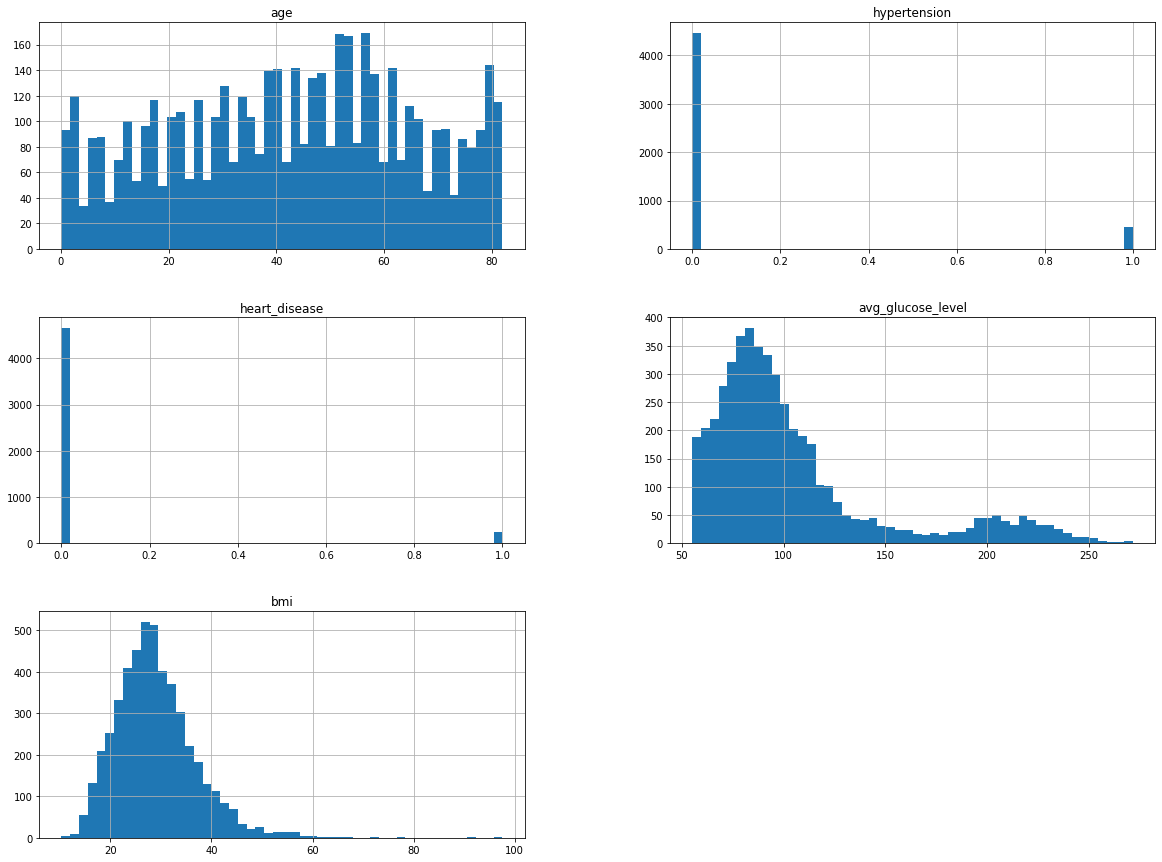

In [4]:
import matplotlib.pyplot as plt

numeric_data.hist(bins=50, figsize=(20,15))
plt.show()

Now, we'll attempt to use balancing strategies to get a less biased sample.

# Oversampling

In [5]:
import imblearn as imb
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X, y)
print(Counter(y_over))

Counter({1: 4700, 0: 4700})


This method used oversampling to match the minority sample to the majority in its entirety.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, train_size=0.5, random_state = 0)

In [7]:
linear_svm = svm.SVC(kernel='linear')
linear_svm.fit(X_train, y_train)

SVC(kernel='linear')

In [8]:
from sklearn.metrics import accuracy_score

prediction = linear_svm.predict(X_test)

accuracy = linear_svm.score(X_test, y_test)

print(accuracy)

0.7755319148936171


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

models = [
          RandomForestClassifier(),
          KNeighborsClassifier()
]

for model in models:
  model.fit(X_train, y_train)
  prediction = model.predict(X_test)
  accuracy = model.score(X_test, y_test)
  print(model, ":", accuracy)


RandomForestClassifier() : 0.981063829787234
KNeighborsClassifier() : 0.9114893617021277


As seen, this model provides an accuracy of 0.77 with a linear svm, however, a random forest classifier provides better accuracy.

Next, we will try with an undersampling method, which will match the majority to the minority.

# Undersampling

In [10]:
from imblearn.under_sampling import NearMiss

undersample = NearMiss(version=1)
X_under, y_under = undersample.fit_resample(X, y)
print(Counter(y_under))

Counter({0: 209, 1: 209})


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, train_size=0.5, random_state = 0)

In [12]:
linear_svm.fit(X_train, y_train)

SVC(kernel='linear')

In [13]:
prediction = linear_svm.predict(X_test)

accuracy = linear_svm.score(X_test, y_test)

print(accuracy)

0.5933014354066986


Unfortunately, through undersampling, the dataset is too small for the model to work effectively. 

# Combination of Both

Luckily, there's more things we can try with an imbalanced dataset. One example is to use SMOTE (Synthetic Minority Over-sampling Technique) oversampling. 

In [14]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=0)
X_resampled, y_resampled = smote_tomek.fit_resample(X_resampled, y_resampled)

print(Counter(y_resampled))

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, train_size=0.5, random_state = 0)

Counter({0: 4327, 1: 4327})


In [15]:
linear_svm.fit(X_train, y_train)

SVC(kernel='linear')

In [16]:
prediction = linear_svm.predict(X_test)

accuracy = linear_svm.score(X_test, y_test)

print(accuracy)

0.8352207071874278


Now that we have an idea of the current quality of the data, let's look at more models.

In [17]:
models = [
          RandomForestClassifier(),
          KNeighborsClassifier()
]

for model in models:
  model.fit(X_train, y_train)
  prediction = model.predict(X_test)
  accuracy = model.score(X_test, y_test)
  print(model, ":", accuracy)


RandomForestClassifier() : 0.9637162006008783
KNeighborsClassifier() : 0.9734226947076496


As seen, the Random Forest Classifier provided the best accuracy with the cleaned resampled data. 